<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/Oro_Verde/S10_11_AIRM_Oro_Verde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**"Oro Verde" Carbon Offset Project**

This notebook implements a complete for the Oro Verde mini-case. The notebook assumes that you are  familiar with the context and have understood the basic optimization model.

In [1]:
#@title **Basic Setup.** We start by importing a few useful modules and reading the case data in.
#@markdown *Click on the "play" button on the left to run this entire cell.*

#@markdown - import/install modules
import numpy as np

import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker 

# import pulp
!pip install pulp &> /dev/null
from pulp import *

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

#@markdown - read the data from a CSV file
url_Q1 = "https://raw.githubusercontent.com/dan-a-iancu/airm/master/Oro_Verde/Oro_Verde_data.csv"
local_file_Q1 = "Oro_Verde_data.csv"   # name of local file where you want to store the downloaded file
aux = urllib.request.urlretrieve(url_Q1, local_file_Q1)    # download from website and save it locally

# read data into a pandas dataframe
mydata = pd.read_csv("Oro_Verde_data.csv", index_col = 0) 

#@markdown - set up any other problem parameters
land_avail = 150000              # available land area (in square feet)
water_avail = 50000              # available water (in gallons)
annual_seq_commit = 1800              # annual sequestration commitment
min_elms = 15   # minimum requirement on elm trees

# create a list with all the types of trees (this will be very useful for creating our decision variables)
tree_types = list(mydata.index)

print("Completed successfully!")

Completed successfully!


### Have a quick look at the data

In [2]:
#@title Print the dataframe with information on tree types
mydata

,SequestrationRate,WaterRequirement,Width,SurvivalRate,SeedlingCost,SeedlingsAvailable
TreeType,,,,,,
Maple,4.30,76.00,130.00,0.70,5.40,"1,000.00"
Elm,3.70,48.00,"3,600.00",0.60,3.20,500.00
Spruce,2.80,34.00,400.00,0.80,4.50,"1,500.00"


# **Q1.**  

Suppose Oro Verde plants 500 maples, 500 elms, and 500 spruces. What would be the total cost, the total amount of water and land required, and the expected annual amount of carbon sequestration delivered in 10 years?


In [3]:
#@title Adjust the planting decisions and calculate and print relevant quantities

#@markdown - adjust how many trees of each type are planted
trees_to_plant = {}
for t in tree_types:
    trees_to_plant[t] = 500   # in Q1, we are planting 500 of each type

#@markdown - calculate and print the total cost, water and land required
cost = sum(trees_to_plant[t] * mydata["SeedlingCost"][t] for t in tree_types)
water_req = sum(trees_to_plant[t] * mydata["WaterRequirement"][t] for t in tree_types)
land_req = sum(trees_to_plant[t] * mydata["Width"][t] for t in tree_types)

print("Total cost: %.2f ($)" %cost)
print("Water required: %.2f (gallons)" % water_req)
print("Land required: %.2f (square feet)" %land_req)

Total cost: 6550.00 ($)
Water required: 79000.00 (gallons)
Land required: 2065000.00 (square feet)


# **Q2.** 
Determine whether the plan in **Q1** is feasible.

*This section assumes that you have already run all the sections before, and particularly **Q1**. If that is not the case, please re-run everything above (e.g., by selecting this cell and choosing **Runtime > Run before**).*

Feasibility means that all the constraints are satisfied: 
 1. the land required does not exceed the land available
 2. the water required does not exceed the water available
 3. the seedlings used do not exceed the seedlings available
 4. the carbon sequestration commitment is met
 5. the number of Elm trees planted exceeds the minimum required

In [4]:
#@title Determine whether all constraints are satisfied
feasible = True # let's assume the proposal is feasible for now, and then check each constraint

# calculate the sequestration achieved
total_seq = sum(trees_to_plant[t] * mydata["SequestrationRate"][t] for t in tree_types)

# water
if (water_req > water_avail) :
    feasible = False
    print("The constraint for water is not satisfied: \n\t Required: {:,.2f}; Available: {:,.2f}" .\
          format(water_req,water_avail))

# land
if (land_req > land_avail) :
    feasible = False
    print("The constraint for land is not satisfied: \n\t Required: {:,.2f} ; Available: {:,.2f}".\
          format(land_req,land_avail))

# seedlings
for t in tree_types:
    if (trees_to_plant[t] > mydata["SeedlingsAvailable"][t]) :
        feasible = False
        print("The constraint for {} seedlings is not satisfied: \n\t Required: {:,.2f} ; Available: {:,.2f}".\
              format(t,water_req,water_avail))

# carbon sequestration
if (total_seq < annual_seq_commit) :
    feasible = False
    print("The constraint for carbon sequestration is not satisfied: \n\t Delivering: {:,.2f} ; Minimum required: {:,.2f}".
          format(total_seq,annual_seq_commit))

# elm min planting
if (trees_to_plant["Elm"] < min_elms) :
    feasible = False
    print("Too few elms planted. \n\t Planting: {:,.2f} ; Minimum required: {:,.2f}".\
          format(trees_to_plant["Elm"],min_elms))

if(feasible) :
    print("Solution is feasible!")
else:
    print("Solution is not feasible.")

The constraint for water is not satisfied: 
	 Required: 79,000.00; Available: 50,000.00
The constraint for land is not satisfied: 
	 Required: 2,065,000.00 ; Available: 150,000.00
Solution is not feasible.


# **Q3**
Set up an **Optimization Model** to determine the optimal number of trees of each type to plant. 

In [5]:
#@title Create the optimization model

#@markdown **Step 1.** Create an empty model
# the model is created with the function "LpProblem"
#   note that we give it a name, and the sense of the objective;
#         LpMinimize for minimization, LpMaximize for maximization
mymodel = LpProblem("Oro_Verde_Tree_Planting_Model", LpMinimize)

#@markdown **Step 2.** Create and add the decision variables
# we create the decisions: note that we specify several arguments:
#   - name: is simply a string used internally, when displaying the model
#   - indexs: this is a list of strings that represent the keys to a dictionary of variables
#             Here, we are making this the list 'tree_types', which means a decision will be created for each element of the list
#   - lowBound: used to specify a lower bound on the value of the decisions 
#             Here, 0 makes them non-negative
#   - upBound: if we want, we can also give an upper bound on the value of a decision
#             Here, None means there is no upper bound
#   - cat: the type of values the decision can take: Continuous (default), Integer or Binary
trees_to_plant = LpVariable.dicts(name="trees_to_plant", \
                                  indexs=tree_types, \
                                  lowBound=0, upBound=None,\
                                  cat="Continuous")

#@markdown **Step 3.** Calculate and add the objective in the model
mymodel += lpSum( trees_to_plant[t] * mydata["SeedlingCost"][t] for t in tree_types)

#@markdown **Step 4.** Calculate and add all the constraints
# we will name the constraints using the type of requirement

# water availability
mymodel += lpSum( trees_to_plant[t] * mydata["WaterRequirement"][t] for t in tree_types) \
<= water_avail, "Water_availability"

# land availability
mymodel += lpSum( trees_to_plant[t] * mydata["Width"][t] for t in tree_types) <= land_avail, \
"Land_availability"

# carbon sequestration commitment
seq_constraint=LpConstraint(lpSum( trees_to_plant[t] * mydata["SurvivalRate"][t] * mydata["SequestrationRate"][t] \
             for t in tree_types ) >= annual_seq_commit, sense=LpConstraintGE, \
             name="seq_constraint")
mymodel += seq_constraint

# minimum elm trees
mymodel += trees_to_plant["Elm"] >= min_elms, "Min_Elms"

# seedling availability for each tree type
for t in tree_types :
  mymodel += trees_to_plant[t] <= mydata["SeedlingsAvailable"][t], "Seedling_Availability_{}".format(t)

#@markdown **Step 5.** You can inspect the model, if you want (uncomment the next line)
# print(mymodel)

#@markdown **Step 6.** Solve the model and display the status
status=mymodel.solve()
print("Status of the optimization: {}".format(LpStatus[status]))

#@markdown **Step 7.** Print the optimal objective and optimal decisions
print("Optimal cost is: {:.3f}".format(value(mymodel.objective)))

costs_Q3 = value(mymodel.objective)

# print solution with a for loop
print("Optimal solution is to plant:")
for t in tree_types :
    print("\t{} : {:,.3f}".format(t,trees_to_plant[t].varValue))

Status of the optimization: Optimal
Optimal cost is: 3213.095
Optimal solution is to plant:
	Maple : 582.798
	Elm : 20.621
	Spruce : 0.000


# **Q4**
Examine how Oro Verde's costs depend on the **additional** sequestration commitment, and plot that against the revenues from the corporation.

*This section assumes that all previous sections have been run, particularly **Q3**.*

In [6]:
#@title Enter a value for how many (additional) pounds of CO2 Oro Verde commits to sequester for the new company:
additional_sequestration = 1 #@param {type:"number"}

total_sequestration = annual_seq_commit + additional_sequestration

# recreate the model
mymodel = LpProblem("Oro_Verde_Tree_Planting_Model", LpMinimize)
trees_to_plant = LpVariable.dicts(name="trees_to_plant", \
                                  indexs=tree_types, \
                                  lowBound=0, upBound=None,\
                                  cat="Continuous")

mymodel += lpSum( trees_to_plant[t] * mydata["SeedlingCost"][t] for t in tree_types)

# water availability
mymodel += lpSum( trees_to_plant[t] * mydata["WaterRequirement"][t] for t in tree_types) \
<= water_avail, "Water_availability"

# land availability
mymodel += lpSum( trees_to_plant[t] * mydata["Width"][t] for t in tree_types) <= land_avail, \
"Land_availability"

# carbon sequestration commitment
seq_constraint=LpConstraint(lpSum( trees_to_plant[t] * mydata["SurvivalRate"][t] * mydata["SequestrationRate"][t] \
             for t in tree_types ) >= total_sequestration, sense=LpConstraintGE, \
             name="seq_constraint")
mymodel += seq_constraint

# minimum elm trees
mymodel += trees_to_plant["Elm"] >= min_elms, "Min_Elms"

# seedling availability for each tree type
for t in tree_types :
  mymodel += trees_to_plant[t] <= mydata["SeedlingsAvailable"][t], "Seedling_Availability_{}".format(t)

# print(mymodel)

status=mymodel.solve()

if LpStatus[status]=="Optimal":
   print("Incremental cost to Oro Verde: ${:.2f}".format(value(mymodel.objective)-costs_Q3))
   print("Average incremental cost per pound to Oro Verde: ${:.2f}".\
         format( (value(mymodel.objective)-costs_Q3)/additional_sequestration ))
elif LpStatus[status]=="Infeasible":
   print("It is not feasible for Oro Verde to meet this commitment.")

Incremental cost to Oro Verde: $1.80
Average incremental cost per pound to Oro Verde: $1.80


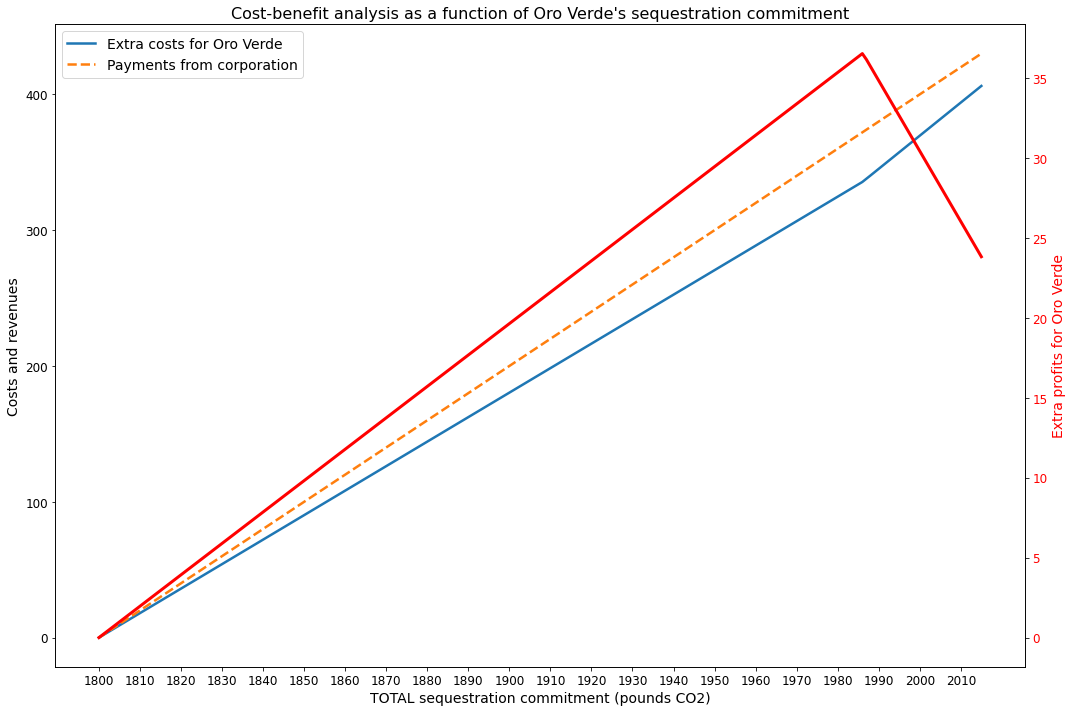

In [7]:
#@title Examine how Oro Verde's **total costs, revenues, profits** depend on **total** sequestration commitments
from numpy import arange   # import the function `arange` from the numpy package

min_seq = 1800
max_seq = 2016

#@markdown - calculate optimal costs for different total sequestration commitments
seq_vals = list(arange(min_seq,max_seq,1))   # set up several values to test for the right-hand-side
objValues = [0]*len(seq_vals)
#print("Sequestration commitment \t |  Shadow price: \n")

for i in range(len(seq_vals)):
    # change the RHS for the constraint
    seq_constraint.changeRHS(seq_vals[i])
    mymodel.solve()
    #print("%.2f \t %.2f " % (seq_vals[i],seq_constraint.pi) )    
    
    objValues[i] = value(mymodel.objective)

#@markdown - determine the incremental costs and revenues
costs_Q3 = 3213.095170    # costs from Q3
payment_per_pound = 2.00   # how much the company is paying per pound

# calculate cost differences relative to Q3
cost_differentials = [ objValues[i] - costs_Q3 for i in range(len(seq_vals)) ]

# calculate payments received
payments_sequestration = [ payment_per_pound * (seq_vals[i] - annual_seq_commit) for i in range(len(seq_vals)) ]

# calculate profit impact
profit_differentials = [ payments_sequestration[i] - cost_differentials[i] for i in range(len(seq_vals)) ]

#@markdown - plot the dependency
# import the relevant functions from pyplot
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15,10))

plt.plot(seq_vals, cost_differentials, linestyle='solid', linewidth=2.5)
plt.plot(seq_vals, payments_sequestration, linestyle='--', linewidth=2.5 )
plt.xlabel("TOTAL sequestration commitment (pounds CO2)",fontsize=14)
plt.ylabel("Costs and revenues", fontsize=14)
plt.legend(["Extra costs for Oro Verde", "Payments from corporation"], fontsize=14)
plt.xticks(list(arange(min_seq,max_seq,10)))

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color2 = 'red'
ax2.set_ylabel('Extra profits for Oro Verde', color=color2, fontsize=14)  # we already handled the x-label with ax1
ax2.plot(seq_vals, profit_differentials, color=color2, linestyle='solid', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color2)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title("Cost-benefit analysis as a function of Oro Verde's sequestration commitment", fontsize=16)

plt.tight_layout()

# Choose 'save_to_file=1' if you want to save the figure to a file
#save_to_file = 1
#if save_to_file == 1 :
#    plt.savefig('Q4_dependency_all.png')